# importing necessary libraries

In [1]:
import os, random                                                                   # for handelling the files
import numpy as np                                                                  # working with arrays and data manupilation
import pandas as pd
import matplotlib.pyplot as plt                                                     # plottting                

from glob import glob                                                               # for handelling file paths
from pathlib import Path                                                            # for handelling file paths
from natsort import natsorted                                                       # for sorting files
from tqdm.auto import tqdm                                                          # for asthetic for loops :)
from collections import Counter                                                     # drawing charts

from sklearn.model_selection import train_test_split                                # splitting the dataset
from sklearn.preprocessing import OneHotEncoder

In [2]:
import torch, torchvision, torchmetrics, torchinfo
import torch.optim as optim                                                         # optimizer
import torch.nn.functional as F                                                     # loss function

from torch import nn                                                                # building neural networks
from torch.utils.data import Dataset                                                # building dataset objects
from torch.utils.data import DataLoader                                             # building data loaders to feed the data to model
from torch.utils.tensorboard import SummaryWriter                                   # for tracking model performance(easy to use)
from torchvision import transforms                                                  # for changes to the dataset content
from torchinfo import summary                                                       # gives a summery of model structure

In [3]:
import cv2
import mediapipe as mp

In [4]:
# here I am checking the cuda device available
if torch.cuda.is_available():
    print("Cuda is available.")
    print(f"Current Device: {torch.cuda.current_device()}, Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Cuda is available.
Current Device: 0, Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
# setting the device to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# working with the data directory

# This function gets Data from directory

In [6]:
def get_landmarks(root: str, shape: tuple):
    ''' 
    This function takes a root string along with a specific image shape as input. and returns shape+label distributions, unreadable+bad image paths
    , MediaPipe landmarks and a list of labels

    Parameters:
        root (string): a string representing the root directory
        shape: (tuple): a tuple representing the image shapes
    '''
    hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)
    all_image_paths= natsorted([str(p) for p in Path(root).glob("**/*.jpg")])

    shape_distribution= Counter()
    label_distribution= Counter()

    filtered_paths= []
    none_cv2_image_paths= []
    none_mp_image_paths= []
    bad_mp_image_paths= []

    hand_landmarks= []
    image_landmarks= []
    image_labels= []
    
    for path in all_image_paths:
        image= cv2.imread(path)
        
        if image is not None:
            shape_distribution[image.shape]+= 1
            
            if image.shape == shape:
                image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results= hands.process(image)
                
                if results.multi_hand_landmarks:
                    if len(results.multi_hand_landmarks)== 1:
                        hand_landmark= results.multi_hand_landmarks[0]
                        landmarks= np.array([[lm.x, lm.y, lm.z] for lm in hand_landmark.landmark]).flatten()
                        label= os.path.basename(os.path.dirname(path))
                        
                        filtered_paths.append(path)
                        hand_landmarks.append(hand_landmark)
                        image_landmarks.append(landmarks)
                        image_labels.append(label)
                        
                        label_distribution[label]+= 1
                        
                    else:
                        bad_mp_image_paths.append(path)
                else:
                    none_mp_image_paths.append(path)
                        
        else:
            none_cv2_image_paths.append(path)
            
    hands.close()
    return hand_landmarks, image_landmarks, image_labels, filtered_paths, none_cv2_image_paths, none_mp_image_paths, bad_mp_image_paths, shape_distribution, label_distribution , all_image_paths

# This Class Analyzes the Data

In [31]:
class ResultAnalyzer:
    def __init__(self, result):
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_hands = mp.solutions.hands
        
        self.hand_landmarks= result[0]
        self.image_landmarks = result[1]
        self.image_labels = result[2]
        self.filtered_paths = result[3]
        self.none_cv2_image_paths = result[4]
        self.none_mp_image_paths = result[5]
        self.bad_mp_image_paths = result[6]
        self.shape_distribution = result[7]
        self.label_distribution = result[8]
        self.all_image_paths= result[9]
        
    def distribution_analyze(self):
        shapes, c1= zip(*self.shape_distribution.items())
        chars, c2= zip(*self.label_distribution.items())

        if sum(x for x in c1) == len(self.all_image_paths)- len(self.none_cv2_image_paths):
            if self.shape_distribution[(1920, 1920, 3)] == len(self.filtered_paths)+len(self.none_mp_image_paths)+len(self.bad_mp_image_paths):
                print("shape distribution test: Passed")
        else:
            print("shape distribution test: Failed")
        if sum(x for x in c2) == len(self.image_labels) and len(chars) == 21:
            print("label distribution test: Passed")
        else:
             print("label distribution test: Failed")

    def landmark_analyze(self):
        fig = plt.figure(figsize=(15, 21)) 
        for i in range(63):
            ax = fig.add_subplot(21, 3, i+1)
            ax.plot(np.sort(np.array(self.image_landmarks).T[i]))
            ax.set_title(f'Landmark {i}', fontsize= 8)
                
        plt.tight_layout()
        plt.show()    

    def draw_random_landmark(self):
        '''
        Draws 3 random hand detections.
        Note! each element of hand_landmarks, image_landmarks, image_labels, and filtered paths can be mapped to an element in the other one
        with the same index
        '''
        a, b, c= random.sample(range(len(self.hand_landmarks)+1), 3)
        path_a, path_b, path_c= self.filtered_paths[a], self.filtered_paths[b], self.filtered_paths[c]
        
        image_a= self.draw_hand_landmarks(cv2.cvtColor(cv2.imread(path_a), cv2.COLOR_BGR2RGB), self.hand_landmarks[a])
        image_b= self.draw_hand_landmarks(cv2.cvtColor(cv2.imread(path_b), cv2.COLOR_BGR2RGB), self.hand_landmarks[b])
        image_c= self.draw_hand_landmarks(cv2.cvtColor(cv2.imread(path_c), cv2.COLOR_BGR2RGB), self.hand_landmarks[c])

        image_data = [(1, image_a, path_a),
                      (2, image_b, path_b),
                      (3, image_c, path_c)]
        
        fig = plt.figure(figsize=(18, 6))  
        for i, img, path in image_data:
            ax = fig.add_subplot(1, 3, i)
            ax.imshow(img)
            ax.set_title(f'label= {os.path.basename(os.path.dirname(path))}')
            plt.axis('off')
        
        plt.show()   

    def draw_hand_landmarks(self, image, landmarks):
        self.mp_drawing.draw_landmarks(image, 
                                       landmarks,
                                       self.mp_hands.HAND_CONNECTIONS,
                                       self.mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                                       self.mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2))
        return image

# Analysing the content

In [28]:
root= 'SigNN Character Database - Copy'
shape= (1920, 1920, 3)

results= get_landmarks(root, shape)

In [32]:
analyser= ResultAnalyzer(results)

In [33]:
analyser.distribution_analyze()

shape distribution test: Passed
label distribution test: Passed


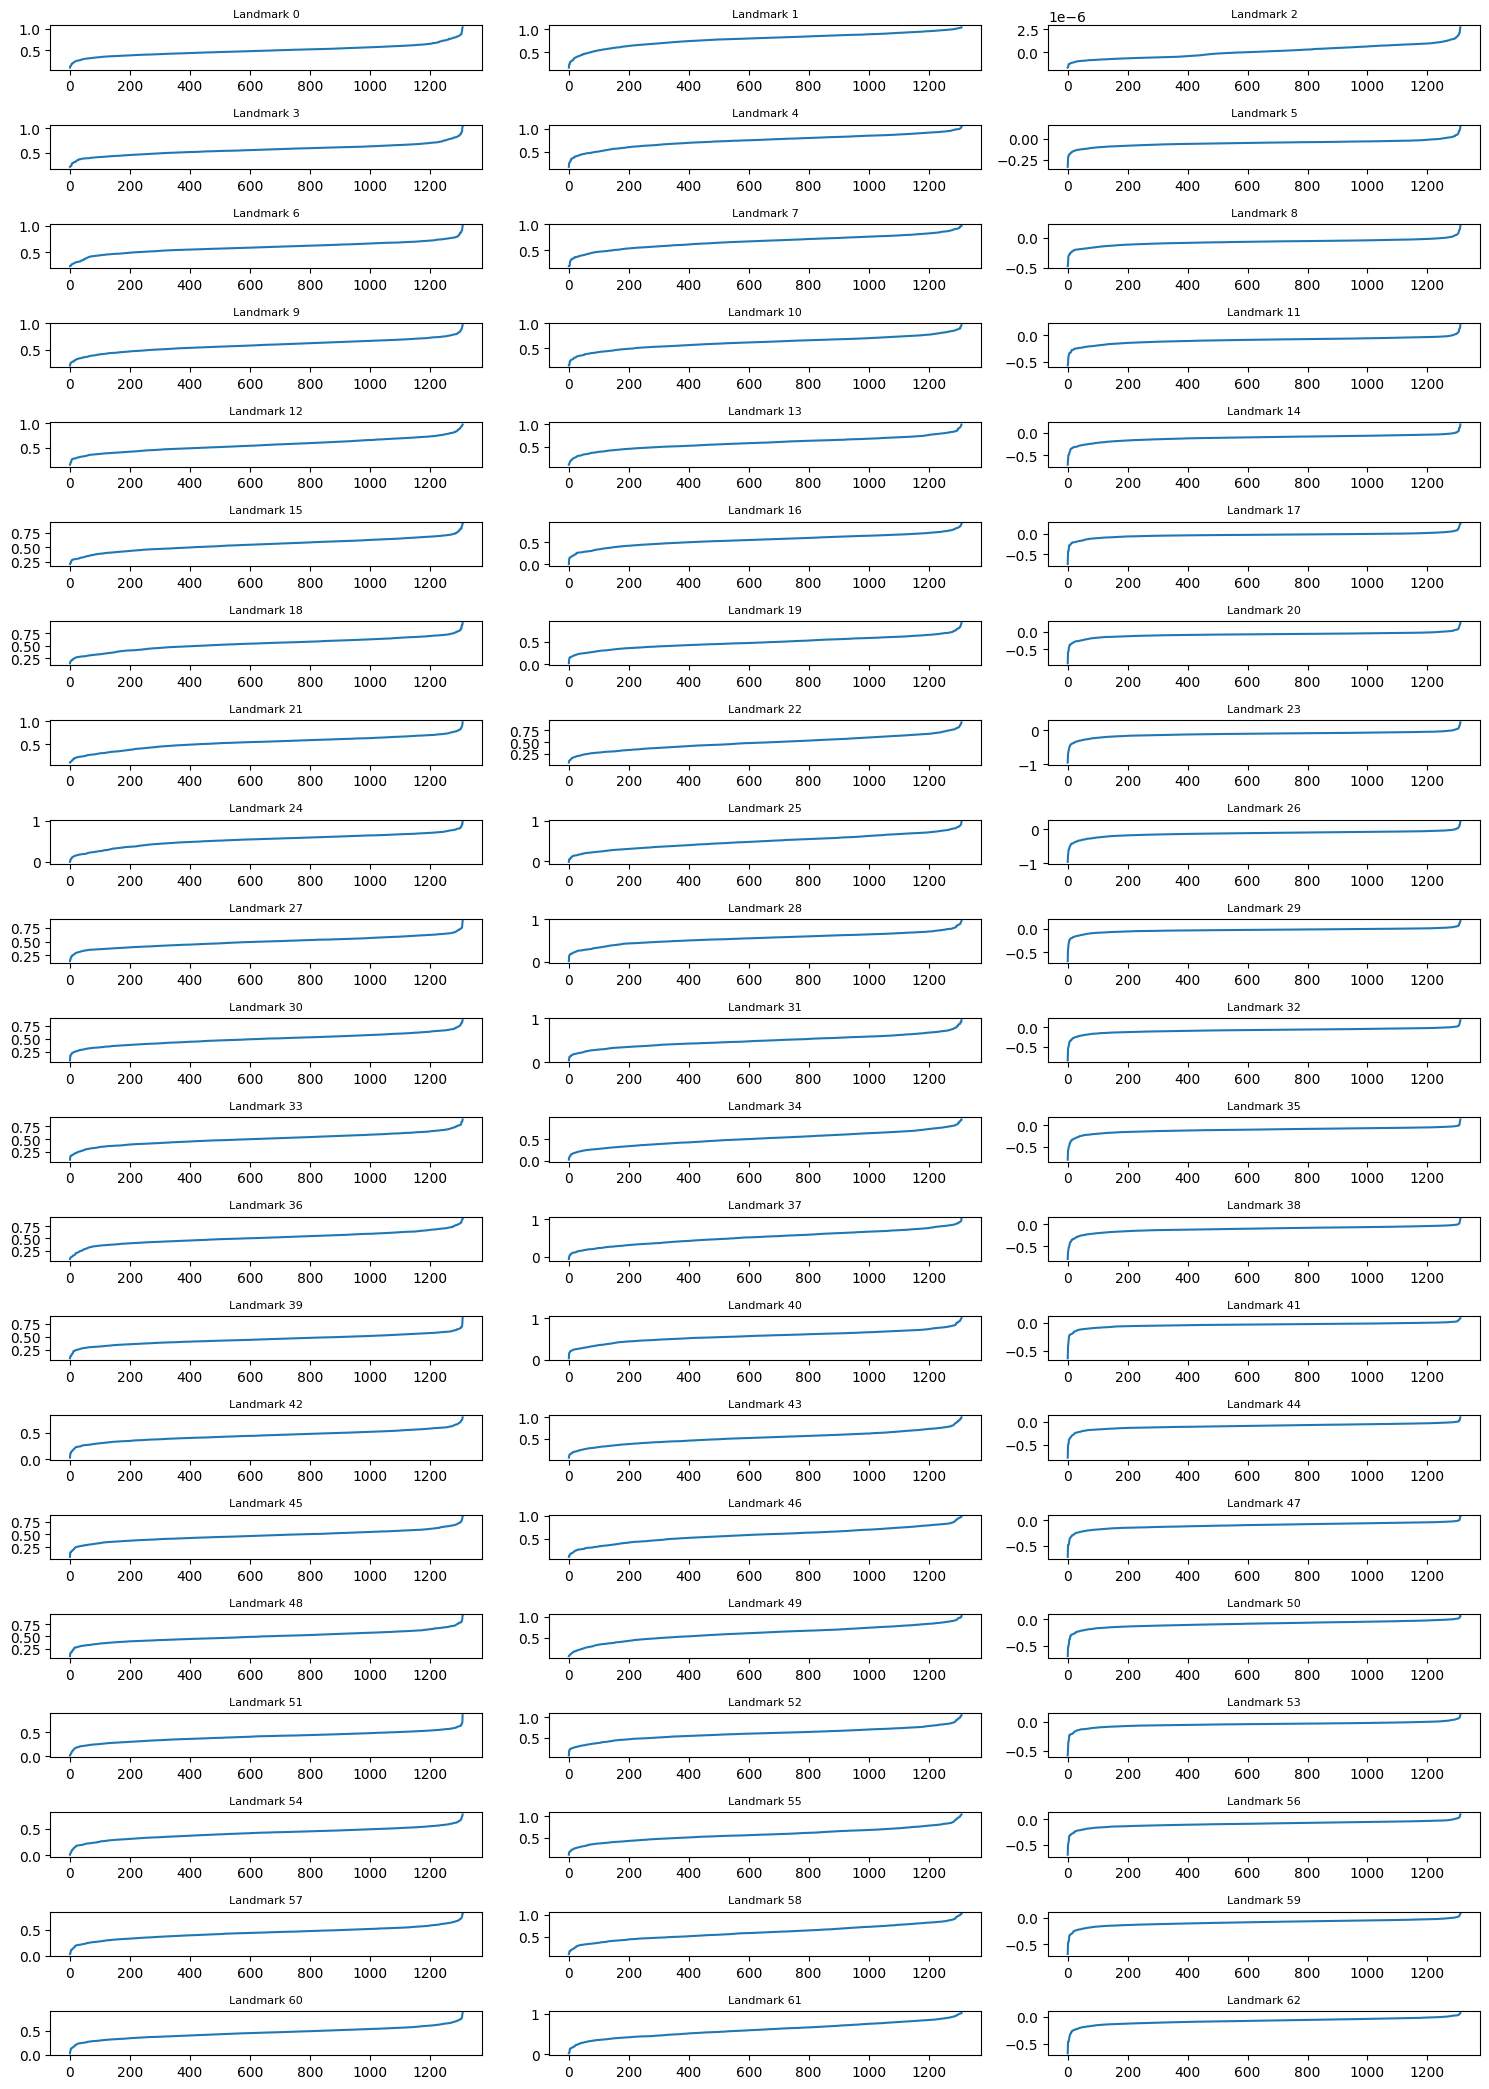

In [34]:
analyser.landmark_analyze()

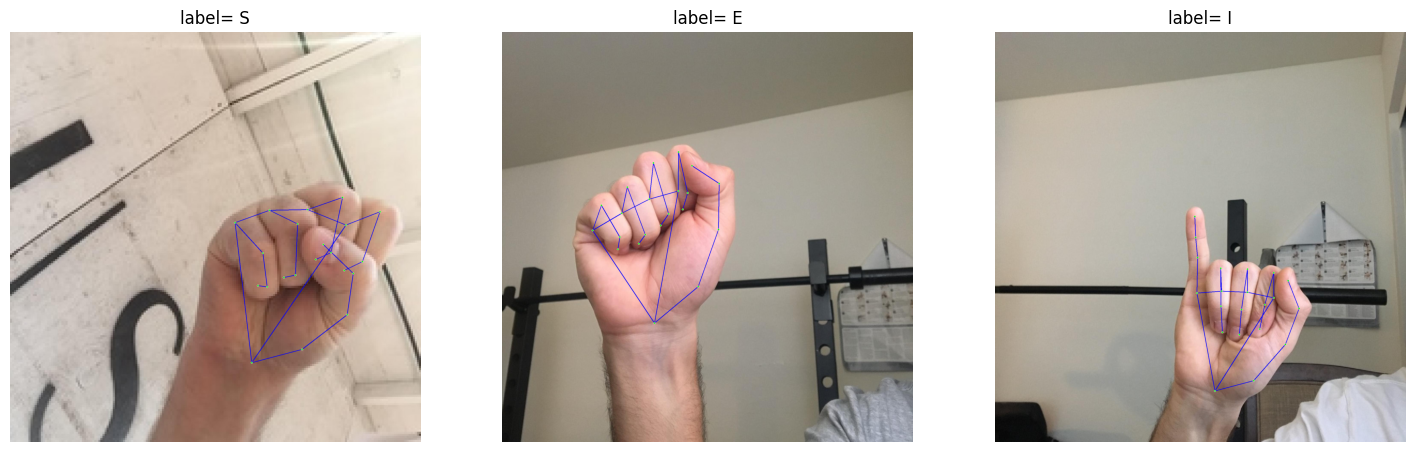

In [35]:
analyser.draw_random_landmark()

![Example Image](signlanguagechars.png)

# Making Dataset class

In [36]:
label_to_idx = {label: idx for idx, label in enumerate(sorted(set(results[2])))}
label_to_idx

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'O': 13,
 'P': 14,
 'Q': 15,
 'R': 16,
 'S': 17,
 'T': 18,
 'U': 19,
 'V': 20}

In [97]:
class LandmarksDataset(Dataset):
    def __init__(self,image_landmarks, image_labels, transform=None):
        self.image_landmarks = image_landmarks
        self.image_labels = image_labels
        self.image_labels_to_idx = {image_label: idx for idx, image_label in enumerate(sorted(set(self.image_labels)))}
        self.num_classes= len(self.image_labels_to_idx)
        self.transform = transform

    def __len__(self):
        return len(self.image_landmarks)

    def __getitem__(self, index):
        image_landmark = torch.from_numpy(self.image_landmarks[index]).float()
        image_label = self.image_labels[index]
        image_label_idx = self.image_labels_to_idx[image_label]
        image_label_encoded= torch.zeros(self.num_classes).float()
        image_label_encoded[image_label_idx]= 1.0

        if self.transform:
            image_landmark = self.transform(image)

        return image_landmark, image_label_encoded

# Class to train model

In [229]:
class ModelManager:
    def __init__(self, model, train_dataloader, test_dataloader, loss_fn, optimizer, writer=None):
        self.model= model
        self.train_dataloader= train_dataloader
        self.test_dataloader= test_dataloader
        self.loss_fn= loss_fn
        self.optimizer= optimizer
        self.writer= writer
 
    def train_step(self, epoch):
        self.model.train()
        train_loss = 0
        for src, tgt in self.train_dataloader:
            src, tgt = src.to(device),tgt.to(device)
            batch_size = src.shape[0]
            src, tgt= src.view(batch_size, 3, 21), tgt.view(batch_size, 1, 21)
            out  = self.model(src, tgt)
            
            loss = self.loss_fn(out, tgt)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()

        avg_train_loss= train_loss/len(self.train_dataloader)
        self.writer.add_scalar("Loss/train", avg_train_loss, epoch)
        print(f"Loss/train, {avg_train_loss} Epoch, {epoch}")
        
        
    def test_step(self, epoch):
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for src, tgt in self.test_dataloader:
                src, tgt = src.to(device),tgt.to(device)
                batch_size = src.shape[0]
                src, tgt= src.view(batch_size, 3, 21), tgt.view(batch_size, 1, 21)
                out = self.model(src, tgt)
            
                loss = self.loss_fn(out, tgt)
                test_loss+= loss.item()

            avg_test_loss= test_loss/len(self.test_dataloader)
            self.writer.add_scalar("Loss/test", avg_test_loss, epoch)
            print(f"Loss/test, {avg_test_loss} Epoch, {epoch}")
           
    def close_writer(self):
        self.writer.flush()
        self.writer.close()

# Putting everything together

1) Datasets and Dataloaders

In [230]:
X_train, x_test, Y_train, y_test= train_test_split(results[1], results[2], test_size=0.2, random_state= 42)

train_dataset= LandmarksDataset(X_train, Y_train)
test_dataset= LandmarksDataset(x_test, y_test)

train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=32, 
                              num_workers=0, 
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32, 
                             num_workers=0, 
                             shuffle=False)                            

In [231]:
for images, labels in train_dataloader:
    # Access the first batch
    print("Images batch reshaped shape:",images.view(32, 3, 21).shape)
    print("Labels batch reshaped shape:",labels.view(32, 1, 21).shape)
    # Optionally, if you want to inspect just one image and label:
    print("Single image shape:", images.view(32, 3, 21)[0].shape)
    print("Single label:", labels.view(32, 1, 21)[0].shape)
    # Break after the first batch to avoid iterating over the entire dataset
    break

Images batch reshaped shape: torch.Size([32, 3, 21])
Labels batch reshaped shape: torch.Size([32, 1, 21])
Single image shape: torch.Size([3, 21])
Single label: torch.Size([1, 21])


2) model: Pytorch TRANSFORMER Model

In [232]:
train_dataset[0][1]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])

In [237]:
model_1= torch.nn.Transformer(d_model=21,
                              nhead=3,
                              num_encoder_layers=6, num_decoder_layers=6,
                              dim_feedforward=18,
                              dropout=0.1,
                              activation='relu',
                              custom_encoder=None, custom_decoder=None, 
                              layer_norm_eps=1e-05, 
                              batch_first=True, norm_first=False,
                              bias=True, device=None, dtype=None).to(device)

2) loss and optim

In [238]:
loss_fn1 = nn.CrossEntropyLoss()
loss_fn2 = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
writer = SummaryWriter()

4) train!

In [239]:
manager= ModelManager(model_1, train_dataloader, test_dataloader, loss_fn2, optimizer, writer)

try:
    epochs = 25
    for epoch in range(epochs):
        manager.train_step(epoch)
finally:
    manager.close_writer() 

Loss/train, 0.7733664368138169 Epoch, 0
Loss/train, 0.711762345198429 Epoch, 1
Loss/train, 0.6722705129421118 Epoch, 2
Loss/train, 0.6382414499918619 Epoch, 3
Loss/train, 0.6113425240372167 Epoch, 4
Loss/train, 0.5848952026078196 Epoch, 5
Loss/train, 0.5617895379210963 Epoch, 6
Loss/train, 0.5418419494773402 Epoch, 7
Loss/train, 0.5218041828184417 Epoch, 8
Loss/train, 0.5028347327853694 Epoch, 9
Loss/train, 0.4858913611282002 Epoch, 10
Loss/train, 0.46732107346708124 Epoch, 11
Loss/train, 0.4497953337250334 Epoch, 12
Loss/train, 0.43334356130975665 Epoch, 13
Loss/train, 0.4177015017379414 Epoch, 14
Loss/train, 0.401882397406029 Epoch, 15
Loss/train, 0.38554183461449365 Epoch, 16
Loss/train, 0.37072564616347803 Epoch, 17
Loss/train, 0.3556685032266559 Epoch, 18
Loss/train, 0.3420886587012898 Epoch, 19
Loss/train, 0.32867524840615014 Epoch, 20
Loss/train, 0.3167409255649104 Epoch, 21
Loss/train, 0.3046844150080825 Epoch, 22
Loss/train, 0.2928507418343515 Epoch, 23
Loss/train, 0.281850994

In [240]:
try:
    epochs = 25
    for epoch in range(epochs):
        manager.test_step(epoch)
finally:
    manager.close_writer() 

Loss/test, 0.2688427103890313 Epoch, 0
Loss/test, 0.2688427103890313 Epoch, 1
Loss/test, 0.2688427103890313 Epoch, 2
Loss/test, 0.2688427103890313 Epoch, 3
Loss/test, 0.2688427103890313 Epoch, 4
Loss/test, 0.2688427103890313 Epoch, 5
Loss/test, 0.2688427103890313 Epoch, 6
Loss/test, 0.2688427103890313 Epoch, 7
Loss/test, 0.2688427103890313 Epoch, 8
Loss/test, 0.2688427103890313 Epoch, 9
Loss/test, 0.2688427103890313 Epoch, 10
Loss/test, 0.2688427103890313 Epoch, 11
Loss/test, 0.2688427103890313 Epoch, 12
Loss/test, 0.2688427103890313 Epoch, 13
Loss/test, 0.2688427103890313 Epoch, 14
Loss/test, 0.2688427103890313 Epoch, 15
Loss/test, 0.2688427103890313 Epoch, 16
Loss/test, 0.2688427103890313 Epoch, 17
Loss/test, 0.2688427103890313 Epoch, 18
Loss/test, 0.2688427103890313 Epoch, 19
Loss/test, 0.2688427103890313 Epoch, 20
Loss/test, 0.2688427103890313 Epoch, 21
Loss/test, 0.2688427103890313 Epoch, 22
Loss/test, 0.2688427103890313 Epoch, 23
Loss/test, 0.2688427103890313 Epoch, 24
